In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
pi = np.pi
sqrt = np.sqrt

In [2]:
# In this notebook:
# - depth from real data
# - speed estimation errors: 
#       all elevs, single elev, single elev dropped, from bottom, from top x (Vz 2DOF, Vz 3DOF, heading 2DOF, heading 3DOF, Wy 3DOF)
#       compare to simulation

In [5]:
srcdir = '../../publicdataset/flows/LK/'
dates = [f'Oct1{i}' for i in range(2,10) if i != 8]
speednames = ['Wy_20','Wy_50','Vz_40','Vx_40','Vxz_40','Vz_60','Vx_60','Vxz_60','Vz_40+Wy_45','Vz_60+Wy_50','Vz_40+Wy_15','Vz_60+Wy_15']
speeds = np.array([[0,0,20],[0,0,50],
          [0,40,0],[40,0,0],[40/sqrt(2),40/sqrt(2),0],
          [0,60,0],[60,0,0],[60/sqrt(2),60/sqrt(2),0],
          [0,40,45],[0,60,50],[0,40,15],[0,60,15]])
fps_effective = 100/5
speedscales = np.array([1000,1000,180/pi])*fps_effective # translations m/frame -> mm/s, rotations rad/frame -> deg/seec
elevsdeg = np.linspace(40,-60,11)
elevs = np.multiply(pi/180,elevsdeg)

center = 20
pixperdeg = 1
patchsz = 25
xinds = np.arange(0,2*patchsz,2,dtype='uint8')
yinds = np.arange(1,2*patchsz,2,dtype='uint8')
nframes = 400
ncams = 2
fps_effective = 100/5

In [6]:
os.listdir(srcdir+'Vz_60')

['Vz_60_Oct12.npz',
 'Vz_60_Oct13.npz',
 'Vz_60_Oct14.npz',
 'Vz_60_Oct15.npz',
 'Vz_60_Oct16.npz',
 'Vz_60_Oct17.npz',
 'Vz_60_Oct19.npz']

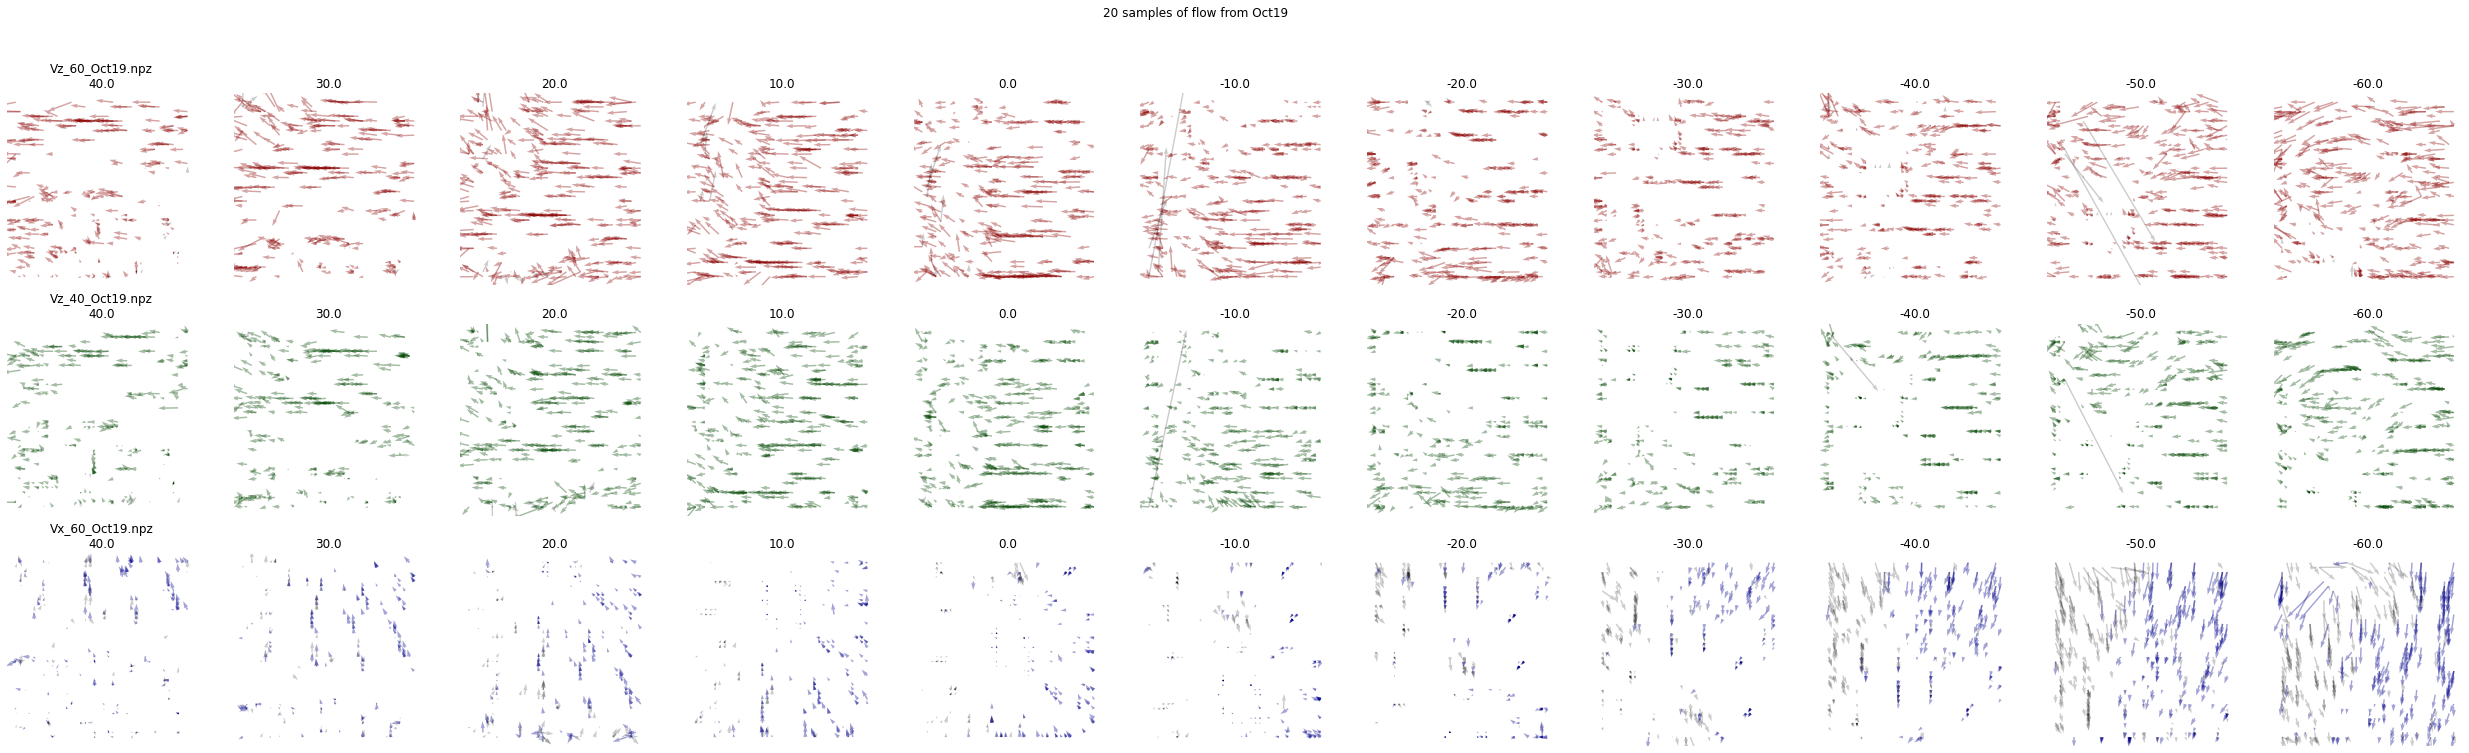

In [7]:
# show flows

date = 'Oct19'
files = [f'{srcdir}{speed}/{speed}_{date}.npz' for speed in ['Vz_60','Vz_40','Vx_60']]
scolors = ['r','g','b']
anglethresh = 90 # exclude anything off by +/- anglethresh deg

def anglediff(a,b,deg=False):
    if deg:
        return np.arctan2(np.sin((a-b)*np.pi/180),np.cos((a-b)*np.pi/180))*180/np.pi
    else:
        return np.arctan2(np.sin(a-b),np.cos(a-b))

plt.figure(figsize=(4*len(elevs),4*len(files)),facecolor='w')
k = 1
for j in range(len(files)):
    data = np.load(files[j])
    p0s = (data['p0s']-center)/pixperdeg
    p1s = (data['p1s']-center)/pixperdeg

    matchsts = np.repeat(data['matchsts'],2,axis=-1)
    p0s[matchsts!=1] = np.nan
    p1s[matchsts!=1] = np.nan
       
    for e in range(len(elevs)):
        plt.subplot(len(files),len(elevs),k)
        k = k+1
        for i in np.arange(0,95,5):
            flow = p1s[1,e,i,:]-p0s[1,e,i,:]
            dx = flow[xinds]
            dy = flow[yinds]
            plt.quiver(p0s[1,e,i,xinds],p0s[1,e,i,yinds],dx,dy,scale=10,color='k',alpha=.2)
            
            angle = 180/np.pi*np.arctan2(dy,dx)
            mag = np.sqrt(dx**2+dy**2)
            dx[np.abs(anglediff(angle,180,deg=True))>anglethresh] = np.nan
            dy[np.abs(anglediff(angle,180,deg=True))>anglethresh] = np.nan
            plt.quiver(p0s[1,e,i,xinds],p0s[1,e,i,yinds],dx,dy,scale=10,color=scolors[j],alpha=.2)
            
            plt.axis('off')
            plt.title(elevsdeg[e])
            if e == 0:
                plt.title(f'{files[j].split("/")[-1]}\n{elevsdeg[e]}')
plt.suptitle(f'20 samples of flow from {date}');

In [10]:
# collect magnitude of horizontal (Vz) flows to estimate nearness

Vzspeedinds = [2,5]

dxs = np.nan*np.ones([len(dates),len(Vzspeedinds),ncams,len(elevs),nframes,patchsz])
angles = np.nan*np.ones_like(dxs)
LKsucc = np.nan*np.ones_like(dxs)
elev_ests = np.nan*np.ones_like(dxs)

for d,date in enumerate(dates):
    print(date)
    for s in range(len(Vzspeedinds)):
        data = np.load(f'{srcdir}{speednames[Vzspeedinds[s]]}/{speednames[Vzspeedinds[s]]}_{date}.npz')
        p0s = (data['p0s']-center)/pixperdeg
        p1s = (data['p1s']-center)/pixperdeg
        matchsts = np.repeat(data['matchsts'],2,axis=-1)
        p0s[matchsts!=1] = np.nan
        for c in range(ncams):
            for e in range(len(elevs)):
                for f in range(nframes):
                    flow = p1s[c,e,f,:]-p0s[c,e,f,:]
                    dx = flow[xinds]
                    dy = flow[yinds]
                    ys = p0s[c,e,f,yinds]
    
                    dxs[d,s,c,e,f,:] = dx
                    LKsucc[d,s,c,e,f,:] = data['matchsts'][c,e,f,:]
                    angles[d,s,c,e,f,:] = 180/pi*np.arctan(dy,dx)
                    elev_ests[d,s,c,e,f,:] = elevsdeg[e]-ys

Oct12
Oct13
Oct14
Oct15
Oct16
Oct17
Oct19


Text(0.5, 1.0, '990124 rejected for non horizontal')

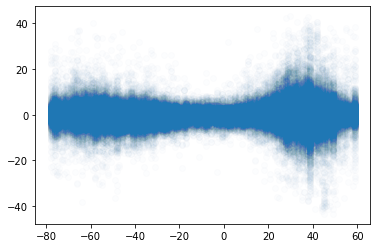

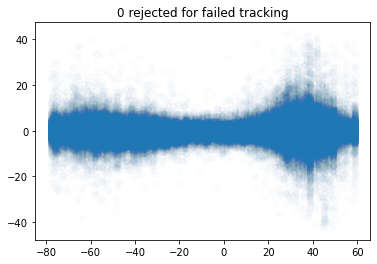

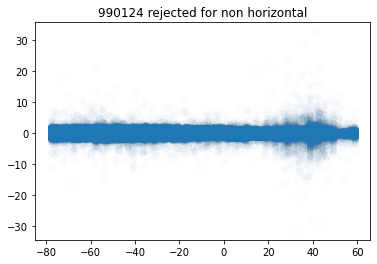

In [11]:
# clean up data

anglethresh = 5 # reject flows off from horizontal by +/- 5 deg

dxs_cleaned = np.copy(dxs)
plt.scatter(np.ndarray.flatten(elev_ests),np.ndarray.flatten(dxs_cleaned),alpha=.01)

# reject failed tracking
bad = LKsucc != 1
presize = np.sum(~np.isnan(dxs_cleaned))
dxs_cleaned[bad] = np.nan
plt.figure()
plt.scatter(np.ndarray.flatten(elev_ests),np.ndarray.flatten(dxs_cleaned),alpha=.01)
plt.title(f'{np.sum(np.logical_and(bad,~np.isnan(dxs)))} rejected for failed tracking')

# reject non horizontal measurements
bad = np.abs(anglediff(angles,0,deg=True))>anglethresh
presize = np.sum(~np.isnan(dxs_cleaned))
dxs_cleaned[bad] = np.nan
plt.figure()
plt.scatter(np.ndarray.flatten(elev_ests),np.ndarray.flatten(dxs_cleaned),alpha=.01)
plt.title(f'{np.sum(bad)} rejected for non horizontal')

(0.0, 10.0)

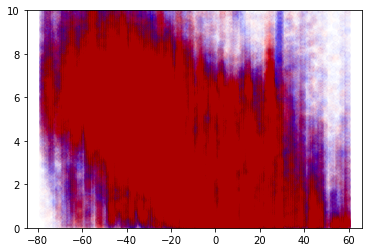

In [12]:
# convert to nearness

fps_effective = 100/5
foclen = 1
scale = 1/pixperdeg*pi/180*foclen*fps_effective # pix/frame to m/s

nearnesses = np.nan*np.ones_like(dxs_cleaned)
nearnesses[:,0,...] = np.abs(dxs_cleaned[:,0,...])*scale/40e-3
nearnesses[:,1,...] = np.abs(dxs_cleaned[:,1,...])*scale/60e-3
plt.figure()
plt.scatter(np.ndarray.flatten(elev_ests[:,0,...]),np.ndarray.flatten(nearnesses[:,0,...]),alpha=.01,c='b')
plt.scatter(np.ndarray.flatten(elev_ests[:,1,...]),np.ndarray.flatten(nearnesses[:,1,...]),alpha=.01,c='r')
plt.ylim(0,10)

Text(0, 0.5, 'nearness estimate (1/m)')

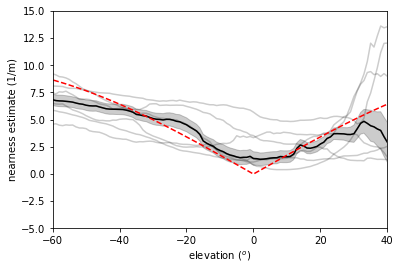

In [15]:
# calculate median nearness (mu)

step = 1
window = 10
degrange = np.arange(-80,60+step,step)
mu_mediansperdeg_bysite = np.nan*np.ones([len(dates),len(degrange)])
    
# collect data across elevation bins
for d in range(len(dates)):
    for dr in range(len(degrange)):
        mus = np.copy(nearnesses[d,...])
        mus[np.abs(elev_ests[d,...]-degrange[dr])>window/2] = np.nan
        mu_mediansperdeg_bysite[d,dr] = np.nanmedian(mus)

# compare across sites
mu_vars = np.nanvar(mu_mediansperdeg_bysite,axis=0)
stderrs = np.sqrt(mu_vars)/np.sqrt(len(dates))

mu_mediansacrosssites = np.nanmedian(mu_mediansperdeg_bysite,axis=0)
mu_vars = np.nanvar(mu_mediansperdeg_bysite,axis=0)
stderrs = np.sqrt(mu_vars)/np.sqrt(len(dates))


plt.figure()
plt.plot(degrange,mu_mediansacrosssites,'k')
plt.fill_between(degrange,mu_mediansacrosssites-stderrs,mu_mediansacrosssites+stderrs,color='k',alpha=.2)
for d in range(len(dates)):
    plt.plot(degrange,mu_mediansperdeg_bysite[d],color='k',alpha=.2)
plt.plot(degrange,10*np.abs(np.sin(degrange*pi/180)),'--r')
plt.plot([42,42],[np.nanmin(mu_mediansperdeg_bysite),np.nanmax(mu_mediansperdeg_bysite)],'--b')
plt.ylim(-5,15)
plt.xlim(-60,40)
plt.xlabel('elevation ($^o$)')
plt.ylabel('nearness estimate (1/m)')

In [156]:
# speed estimation errors

In [7]:
# make flows at arbitrary points, estimate speed arbitrary points

# make ground truth templates

def pitch(a):
    return np.array([[1,0,0],[0,np.cos(a),np.sin(a)],[0,-np.sin(a),np.cos(a)]])

def yaw(a):
    return np.array([[np.cos(a),0,np.sin(a)],[0,1,0],[-np.sin(a),0,np.cos(a)]])

def roll(a):
    return np.array([[np.cos(a),-np.sin(a),0],[np.sin(a),np.cos(a),0],[0,0,1]])

def makeR(theta,alpha=0,gamma=0):
    return np.matmul(np.matmul(roll(gamma),pitch(alpha)),yaw(theta))

def nearness_local(x,y,geometry='natural',r=1,f=1,alpha=0):
    if geometry == 'sphere':
        mu = 1/r*np.sqrt(1-(x**2+y**2))
    elif geometry == 'floor':
        mu = np.abs(np.sin(y+alpha))/r * (y+alpha < 0)
    elif geometry == 'natural':
        mu = 10*np.abs(np.sin(alpha+np.arctan2(y,f))) # 10 cm above/10 cm below (Z*.1m -> mu*10/m)
        mu[(alpha+np.arctan2(y,f))>42*pi/180] = 0 # remove geometry cues above Snell's window
    return mu

def getflow_local(x,y,Vx=0,Vy=0,Vz=0,Wx=0,Wy=0,Wz=0,
              geometry='natural',r=1,f=1,theta=0,alpha=0):
    
    # rotate velocity to local patch
    V0 = [[Vx,Vy,Vz],[Wx,Wy,Wz]]
    R = makeR(theta,alpha)
    V = np.transpose(np.matmul(R,np.transpose(V0)))
    Vx,Vy,Vz = V[0]
    Wx,Wy,Wz = V[1]
    
    # get nearness
    mu = nearness_local(geometry=geometry,x=x,y=y,r=r,alpha=alpha)
    
    # compute local flow
    flow_horiz = -Vx*f*mu + Vz*mu*x - Wx*x*y/f + Wy*(f**2+x**2)/f - Wz*y
    flow_vert = -Vy*f*mu + Vz*mu*y - Wx*(f**2+y**2)/f + Wy*x*y/f + Wz*x
    
    return flow_horiz,flow_vert

# multimodal flow patches
def getflow_multimodal(xs,ys,Vx=0,Vy=0,Vz=0,Wx=0,Wy=0,Wz=0,
              geometry='natural',r=1,f=1,thetas=[0,0],alphas=[0,0]):
    flow_horiz = np.zeros(patchsz*len(thetas))
    flow_vert = np.zeros_like(flow_horiz)
    for i in range(len(thetas)):
        flow_h, flow_v = getflow_local(Vx=Vx,Vy=Vy,Vz=Vz,Wx=Wx,Wy=Wy,Wz=Wz,
              geometry=geometry,r=r,
              x=xs[i*patchsz:(i+1)*patchsz],y=ys[i*patchsz:(i+1)*patchsz],theta=thetas[i],alpha=alphas[i])
        flow_horiz[i*patchsz:(i+1)*patchsz] = flow_h
        flow_vert[i*patchsz:(i+1)*patchsz] = flow_v
    return flow_horiz,flow_vert

# predict self motion velocity from multimodal flow patch
def getvel_multimodal(xs,ys,flow,thetas=[0,0],alphas=[0,0],geometry='natural',DOFs=3):
   
    vxtemplate = np.ndarray.flatten(np.array(getflow_multimodal(xs,ys,Vx=1,thetas=thetas,alphas=alphas,geometry=geometry)))
    vytemplate = np.ndarray.flatten(np.array(getflow_multimodal(xs,ys,Vy=1,thetas=thetas,alphas=alphas,geometry=geometry)))
    vztemplate = np.ndarray.flatten(np.array(getflow_multimodal(xs,ys,Vz=1,thetas=thetas,alphas=alphas,geometry=geometry)))
    wxtemplate = np.ndarray.flatten(np.array(getflow_multimodal(xs,ys,Wx=1,thetas=thetas,alphas=alphas,geometry=geometry)))
    wytemplate = np.ndarray.flatten(np.array(getflow_multimodal(xs,ys,Wy=1,thetas=thetas,alphas=alphas,geometry=geometry)))
    wztemplate = np.ndarray.flatten(np.array(getflow_multimodal(xs,ys,Wz=1,thetas=thetas,alphas=alphas,geometry=geometry)))    
        
    if DOFs == 1:
        templates = wytemplate #note: in previous experiments (GenSim) 1DOF was Vz
    elif DOFs == 2:
        templates = np.stack([vxtemplate,vztemplate])
    elif DOFs == 3:
        templates = np.stack([vxtemplate,vztemplate,wytemplate])
    elif DOFs == 6:
        templates = np.stack([vxtemplate,vytemplate,vztemplate,wxtemplate,wytemplate,wztemplate])
    
    # remove locations where flow is missing
    weights = np.ones(np.shape(flow)[1])
    weights[np.isnan(flow[0])] = 0
    weights[np.isnan(flow[1])] = 0
    flow[0][np.isnan(flow[0])] = 0
    flow[1][np.isnan(flow[1])] = 0
    templates[np.isnan(templates)] = 0
    

    # weight template and sample
    template = np.transpose(templates*np.tile(weights,[DOFs,2]))
    sample = np.transpose(np.ndarray.flatten(np.array(flow))*np.tile(weights,[1,2]))
     
    # solve for self motion
    pred,_,_,_ = np.linalg.lstsq(template,sample,rcond=-1)
    return np.squeeze(pred)

Text(0.5, 1.0, 'Wy template')

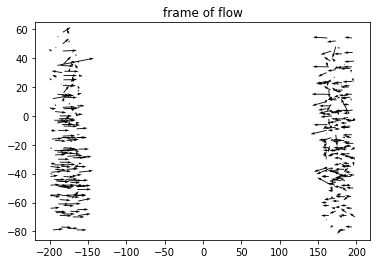

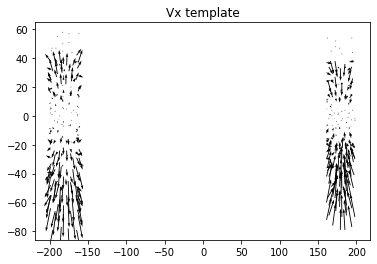

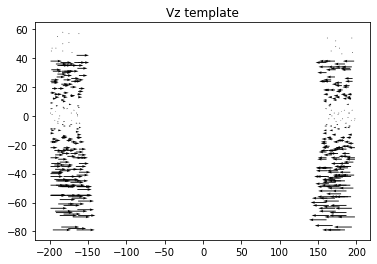

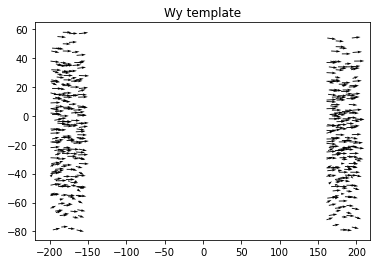

In [8]:
# show whole field templates, flow

elevsadd,azimsadd = np.meshgrid(elevsdeg,[-180,180])
elevsadd = np.ndarray.flatten(np.repeat(np.expand_dims(elevsadd,axis=-1),patchsz,axis=-1))
azimsadd = np.ndarray.flatten(np.repeat(np.expand_dims(azimsadd,axis=-1),patchsz,axis=-1))

f = 100

p0s = (data['p0s']-center)/pixperdeg*pi/180
p1s = (data['p1s']-center)/pixperdeg*pi/180
matchsts = np.repeat(data['matchsts'],2,axis=-1)
flows = p1s-p0s
flows[matchsts!=1] = np.nan

xs = np.ndarray.flatten(p0s[:,:,f,xinds])
ys = np.ndarray.flatten(p0s[:,:,f,yinds])
x2 = np.ndarray.flatten(xs*180/pi)+azimsadd
y2 = np.ndarray.flatten(ys*180/pi)+elevsadd

flow = [np.ndarray.flatten(flows[:,:,f,xinds]),np.ndarray.flatten(flows[:,:,f,yinds])]
plt.figure()
plt.quiver(x2,y2,np.ndarray.flatten(flow[0]),-np.ndarray.flatten(flow[1]))
plt.title('frame of flow')

vxtemplate = np.array(getflow_multimodal(xs,ys,Vx=1,thetas=np.repeat([-pi/2,pi/2],len(elevs)),alphas=np.tile(elevs,ncams)))
plt.figure()
plt.quiver(x2,y2,vxtemplate[0],-vxtemplate[1])
plt.title('Vx template')

vztemplate = np.array(getflow_multimodal(xs,ys,Vz=1,thetas=np.repeat([-pi/2,pi/2],len(elevs)),alphas=np.tile(elevs,ncams)))
plt.figure()
plt.quiver(x2,y2,vztemplate[0],-vztemplate[1])
plt.title('Vz template')

wytemplate = np.array(getflow_multimodal(xs,ys,Wy=1,thetas=np.repeat([-pi/2,pi/2],len(elevs)),alphas=np.tile(elevs,ncams)))
plt.figure()
plt.quiver(x2,y2,wytemplate[0],-wytemplate[1])
plt.title('Wy template')

In [16]:
# prepare several self motion estimates

ests_2DOF = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,2])
ests_3DOF = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,3])

ests_2DOF_leaveoneout = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,2])
ests_3DOF_leaveoneout = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,3])

ests_2DOF_frombottom = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,2])
ests_3DOF_frombottom = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,3])

ests_2DOF_fromtop = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,2])
ests_3DOF_fromtop = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,3])

ests_2DOF_wholefield = np.nan*np.ones([len(dates),len(speeds),nframes,2])
ests_3DOF_wholefield = np.nan*np.ones([len(dates),len(speeds),nframes,3])

recalculate = False # recalculate errors, if False use precalculated estimates in ./estimates

In [49]:
# estimate self motion from optic flow

if recalculate:

    for d in range(len(dates)):
        print(dates[d])

        for s in range(len(speeds)):
            print('\t'+speednames[s])


            data = np.load(f'{srcdir}{speednames[s]}/{speednames[s]}_{dates[d]}.npz')
            p0s = (data['p0s']-center)/pixperdeg*pi/180
            p1s = (data['p1s']-center)/pixperdeg*pi/180
            matchsts = np.repeat(data['matchsts'],2,axis=-1)
            flows = p1s-p0s
            flows[matchsts!=1] = np.nan

            if np.all(np.isnan(flows)):
                continue


            for f in range(nframes):
                if np.all(np.isnan(flows[:,:,f,:])):
                    continue


                if np.all(~np.isnan(ests_2DOF_frombottom[d,s,:,f])):
                    continue


                ests_2DOF_wholefield[d,s,f] = getvel_multimodal(np.ndarray.flatten(p0s[:,:,f,xinds]),
                                                         np.ndarray.flatten(p0s[:,:,f,yinds]),
                                                         [np.ndarray.flatten(flows[:,:,f,xinds]),np.ndarray.flatten(flows[:,:,f,yinds])],
                                                         thetas=np.repeat([-pi/2,pi/2],len(elevs)),
                                                         alphas=np.tile(elevs,2),
                                                         DOFs=2)
                ests_3DOF_wholefield[d,s,f] = getvel_multimodal(np.ndarray.flatten(p0s[:,:,f,xinds]),
                                                         np.ndarray.flatten(p0s[:,:,f,yinds]),
                                                         [np.ndarray.flatten(flows[:,:,f,xinds]),np.ndarray.flatten(flows[:,:,f,yinds])],
                                                         thetas=np.repeat([-pi/2,pi/2],len(elevs)),
                                                         alphas=np.tile(elevs,2),
                                                         DOFs=3)

                for e in range(len(elevs)):



                    ests_2DOF[d,s,e,f] = getvel_multimodal(np.ndarray.flatten(p0s[:,e,f,xinds]),
                                                           np.ndarray.flatten(p0s[:,e,f,xinds]),
                                                           [np.ndarray.flatten(flows[:,e,f,xinds]),np.ndarray.flatten(flows[:,e,f,yinds])],
                                                           thetas=[-pi/2,pi/2],
                                                           alphas=[elevs[e],elevs[e]],
                                                           DOFs=2)
                    ests_3DOF[d,s,e,f] = getvel_multimodal(np.ndarray.flatten(p0s[:,e,f,xinds]),
                                                           np.ndarray.flatten(p0s[:,e,f,xinds]),
                                                           [np.ndarray.flatten(flows[:,e,f,xinds]),np.ndarray.flatten(flows[:,e,f,yinds])],
                                                           thetas=[-pi/2,pi/2],
                                                           alphas=[elevs[e],elevs[e]],
                                                           DOFs=3)

                    inds = [ind for ind in range(len(elevs)) if ind !=e]
                    p0s_temp = p0s[:,inds,:,:]
                    flows_temp = flows[:,inds,:,:]
                    ests_2DOF_leaveoneout[d,s,e,f] = getvel_multimodal(np.ndarray.flatten(p0s_temp[:,:,f,xinds]),
                                                         np.ndarray.flatten(p0s_temp[:,:,f,yinds]),
                                                         [np.ndarray.flatten(flows_temp[:,:,f,xinds]),np.ndarray.flatten(flows_temp[:,:,f,yinds])],
                                                         thetas=np.repeat([-pi/2,pi/2],len(elevs)-1),
                                                         alphas=np.tile(elevs[inds],2),
                                                         DOFs=2)

                    ests_3DOF_leaveoneout[d,s,e,f] = getvel_multimodal(np.ndarray.flatten(p0s_temp[:,:,f,xinds]),
                                                         np.ndarray.flatten(p0s_temp[:,:,f,yinds]),
                                                         [np.ndarray.flatten(flows_temp[:,:,f,xinds]),np.ndarray.flatten(flows_temp[:,:,f,yinds])],
                                                         thetas=np.repeat([-pi/2,pi/2],len(elevs)-1),
                                                         alphas=np.tile(elevs[inds],2),
                                                         DOFs=3)

                    inds = [ind for ind in range(len(elevs)) if ind >= e] # >= because elevs go max to min
                    p0s_temp = p0s[:,inds,:,:]
                    flows_temp = flows[:,inds,:,:]

                    ests_2DOF_frombottom[d,s,e,f] = getvel_multimodal(np.ndarray.flatten(p0s_temp[:,:,f,xinds]),
                                                         np.ndarray.flatten(p0s_temp[:,:,f,yinds]),
                                                         [np.ndarray.flatten(flows_temp[:,:,f,xinds]),np.ndarray.flatten(flows_temp[:,:,f,yinds])],
                                                         thetas=np.repeat([-pi/2,pi/2],len(inds)),
                                                         alphas=np.tile(elevs[inds],2),
                                                         DOFs=2)

                    ests_3DOF_frombottom[d,s,e,f] = getvel_multimodal(np.ndarray.flatten(p0s_temp[:,:,f,xinds]),
                                                         np.ndarray.flatten(p0s_temp[:,:,f,yinds]),
                                                         [np.ndarray.flatten(flows_temp[:,:,f,xinds]),np.ndarray.flatten(flows_temp[:,:,f,yinds])],
                                                         thetas=np.repeat([-pi/2,pi/2],len(inds)),
                                                         alphas=np.tile(elevs[inds],2),
                                                         DOFs=3)

                    inds = [ind for ind in range(len(elevs)) if ind <= e]
                    p0s_temp = p0s[:,inds,:,:]
                    flows_temp = flows[:,inds,:,:]

                    ests_2DOF_fromtop[d,s,e,f] = getvel_multimodal(np.ndarray.flatten(p0s_temp[:,:,f,xinds]),
                                                         np.ndarray.flatten(p0s_temp[:,:,f,yinds]),
                                                         [np.ndarray.flatten(flows_temp[:,:,f,xinds]),np.ndarray.flatten(flows_temp[:,:,f,yinds])],
                                                         thetas=np.repeat([-pi/2,pi/2],len(inds)),
                                                         alphas=np.tile(elevs[inds],2),
                                                         DOFs=2)

                    ests_3DOF_fromtop[d,s,e,f] = getvel_multimodal(np.ndarray.flatten(p0s_temp[:,:,f,xinds]),
                                                         np.ndarray.flatten(p0s_temp[:,:,f,yinds]),
                                                         [np.ndarray.flatten(flows_temp[:,:,f,xinds]),np.ndarray.flatten(flows_temp[:,:,f,yinds])],
                                                         thetas=np.repeat([-pi/2,pi/2],len(inds)),
                                                         alphas=np.tile(elevs[inds],2),
                                                         DOFs=3)


                np.savez('./estimates/ests',ests_2DOF=ests_2DOF,
                              ests_3DOF=ests_3DOF,
                              ests_2DOF_frombottom=ests_2DOF_frombottom,
                              ests_3DOF_frombottom=ests_3DOF_frombottom,
                              ests_2DOF_fromtop=ests_2DOF_fromtop,
                              ests_3DOF_fromtop=ests_3DOF_fromtop,
                              ests_2DOF_wholefield=ests_2DOF_wholefield,
                              ests_3DOF_wholefield=ests_3DOF_wholefield,
                              ests_2DOF_leaveoneout=ests_2DOF_leaveoneout,
                              ests_3DOF_leaveoneout=ests_3DOF_leaveoneout)

Oct12
	Wy_20
	Wy_50
	Vz_40
	Vx_40
	Vxz_40
	Vz_60
	Vx_60
	Vxz_60
	Vz_40+Wy_45
	Vz_60+Wy_50
	Vz_40+Wy_15
	Vz_60+Wy_15
Oct13
	Wy_20
	Wy_50
	Vz_40
	Vx_40
	Vxz_40
	Vz_60
	Vx_60
	Vxz_60
	Vz_40+Wy_45
	Vz_60+Wy_50
	Vz_40+Wy_15
	Vz_60+Wy_15
Oct14
	Wy_20
	Wy_50
	Vz_40
	Vx_40
	Vxz_40
	Vz_60
	Vx_60
	Vxz_60
	Vz_40+Wy_45
	Vz_60+Wy_50
	Vz_40+Wy_15
	Vz_60+Wy_15
Oct15
	Wy_20
	Wy_50
	Vz_40
	Vx_40
	Vxz_40
	Vz_60
	Vx_60
	Vxz_60
	Vz_40+Wy_45
	Vz_60+Wy_50
	Vz_40+Wy_15
	Vz_60+Wy_15
Oct16
	Wy_20
	Wy_50
	Vz_40
	Vx_40
	Vxz_40
	Vz_60
	Vx_60
	Vxz_60
	Vz_40+Wy_45
	Vz_60+Wy_50
	Vz_40+Wy_15
	Vz_60+Wy_15
Oct17
	Wy_20
	Wy_50
	Vz_40
	Vx_40
	Vxz_40
	Vz_60
	Vx_60
	Vxz_60
	Vz_40+Wy_45
	Vz_60+Wy_50
	Vz_40+Wy_15
	Vz_60+Wy_15
Oct19
	Wy_20
	Wy_50
	Vz_40
	Vx_40
	Vxz_40
	Vz_60
	Vx_60
	Vxz_60
	Vz_40+Wy_45
	Vz_60+Wy_50
	Vz_40+Wy_15
	Vz_60+Wy_15


In [ ]:
#********

In [20]:
# load precalcalated optic flow estimates

if not recalculate:
    ests = np.load('./estimates/ests.npz')
    ests_2DOF = ests['ests_2DOF']
    ests_3DOF = ests['ests_3DOF']
    ests_2DOF_leaveoneout = ests['ests_2DOF_leaveoneout']
    ests_3DOF_leaveoneout = ests['ests_3DOF_leaveoneout']
    ests_2DOF_wholefield = ests['ests_2DOF_wholefield']
    ests_3DOF_wholefield = ests['ests_3DOF_wholefield']
    ests_2DOF_frombottom = ests['ests_2DOF_frombottom']
    ests_3DOF_frombottom = ests['ests_3DOF_frombottom']
    ests_2DOF_fromtop = ests['ests_2DOF_fromtop']
    ests_3DOF_fromtop = ests['ests_3DOF_fromtop']

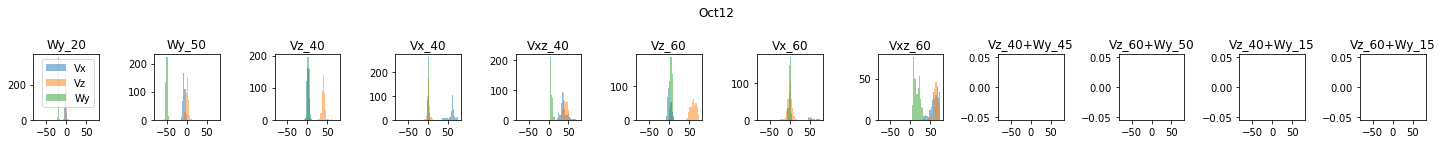

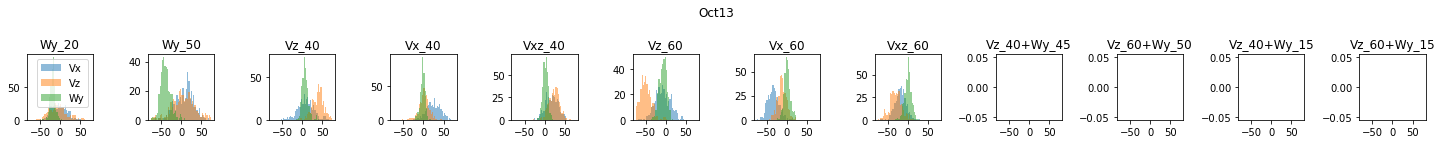

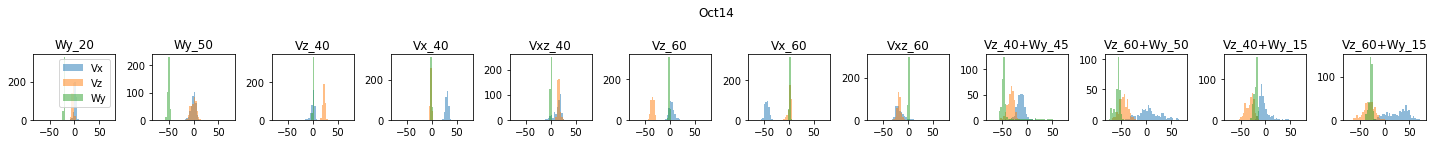

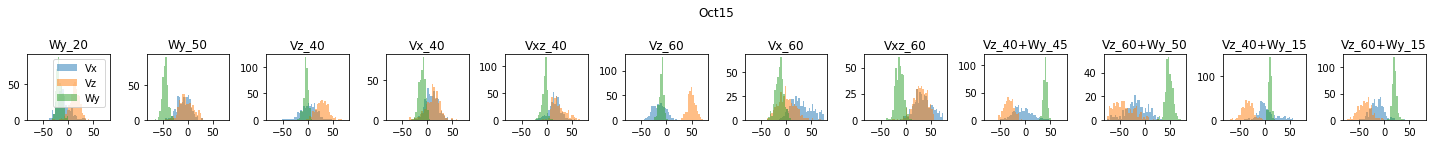

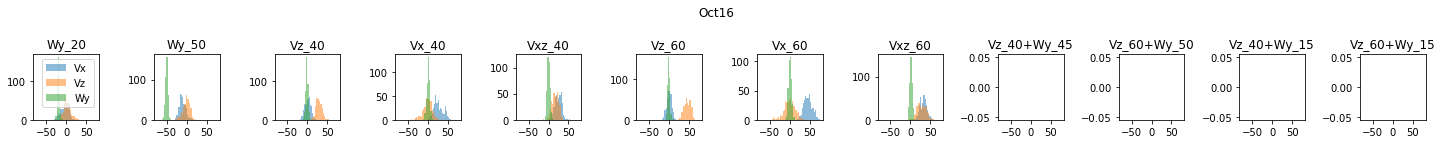

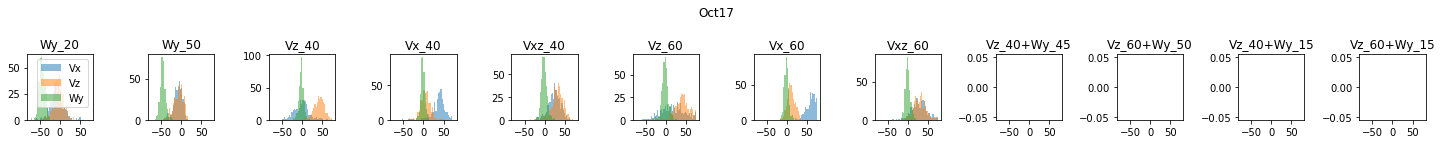

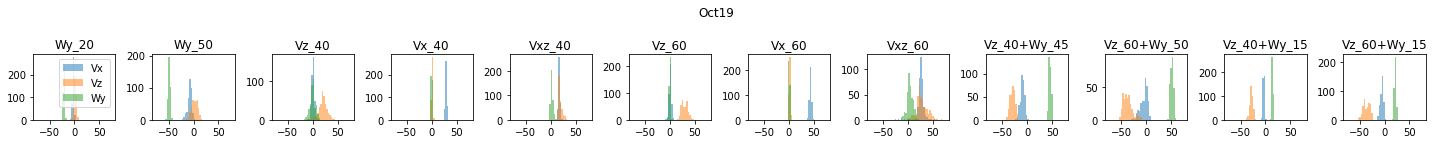

In [51]:
# show each trajectory at each site
rng = [-75,75]
bins = 50
for d,date in enumerate(dates):
    plt.figure(figsize=(20,2),facecolor='w')
    for s in range(len(speeds)):
        plt.subplot(1,len(speeds),s+1)
        ests = ests_3DOF_wholefield[d,s,:,:]
        plt.hist(ests[:,0]*1000*fps_effective,alpha=.5,range=rng,bins=bins,label=('Vx'))
        plt.hist(ests[:,1]*1000*fps_effective,alpha=.5,range=rng,bins=bins,label=('Vz'))
        plt.hist(ests[:,2]*180/pi*fps_effective,alpha=.5,range=rng,bins=bins,label=('Wy'));
        plt.title(speednames[s])
        if s==0:
            plt.legend()
    plt.suptitle(date)
    plt.tight_layout()

In [21]:
# based on these histograms, correct for camera placement errors
estset = [ests_2DOF,ests_3DOF,ests_2DOF_wholefield,ests_3DOF_wholefield,ests_2DOF_leaveoneout,ests_3DOF_leaveoneout,
          ests_2DOF_frombottom,ests_3DOF_frombottom,ests_2DOF_fromtop,ests_3DOF_fromtop]
for ests in estset:
    if np.shape(ests)[-1] > 2:
        # all Wy backward
        ests[...,2] = -ests[...,2]
        # except Oct15 and Oct19 circular trajectories
        ests[3,-4:,...,2] = -ests[3,-4,...,2]
        ests[-1,-4:,...,2] = -ests[-1,-4,...,2]
   # translations negative on Oct13 and Oct14
    ests[1,5:8,...,0:2] = -ests[1,5:8,...,0:2]
    ests[2,5:8,...,0:2] = -ests[2,5:8,...,0:2]
    # remove missing sites from circular trajectories
    ests[0:2,-4:,...] = np.nan
    # Vz negative on circular trajectories
    ests[:,-4:,...,1] = -ests[:,-4:,...,1]

    # convert to mm/s and deg/sec
    for DOF in range(np.shape(ests)[-1]):
        ests[...,DOF] = speedscales[DOF]*ests[...,DOF]

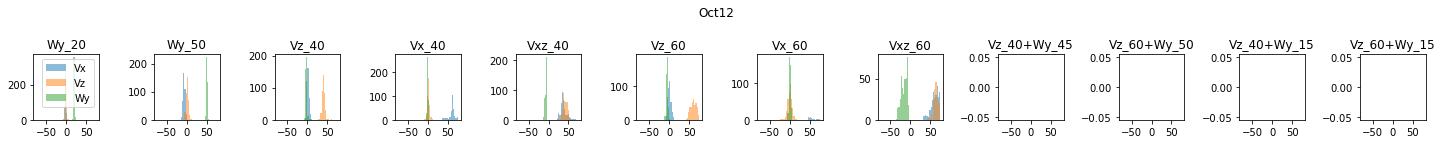

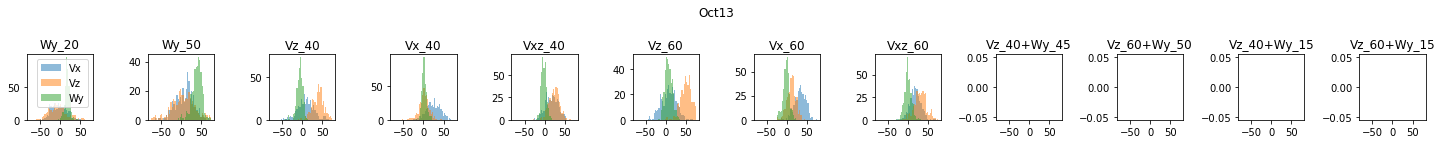

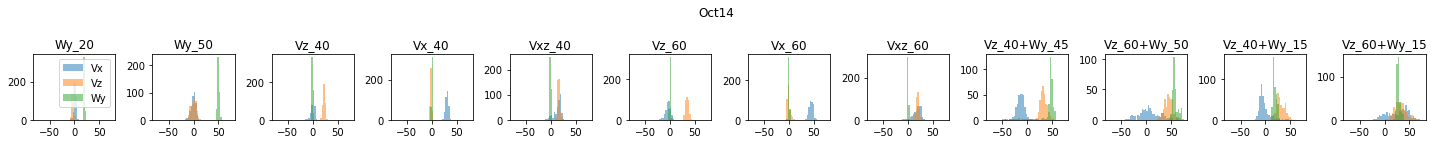

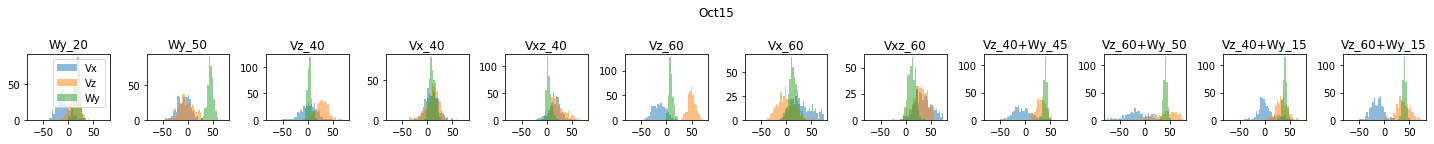

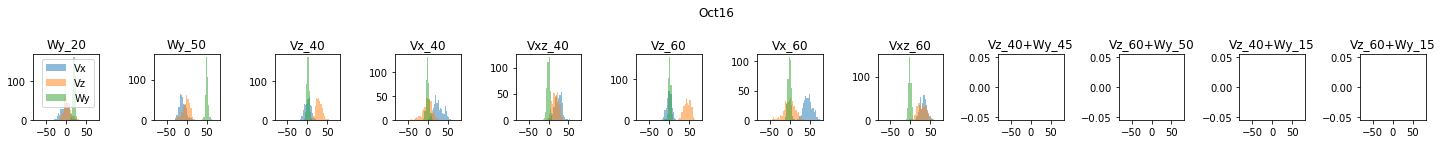

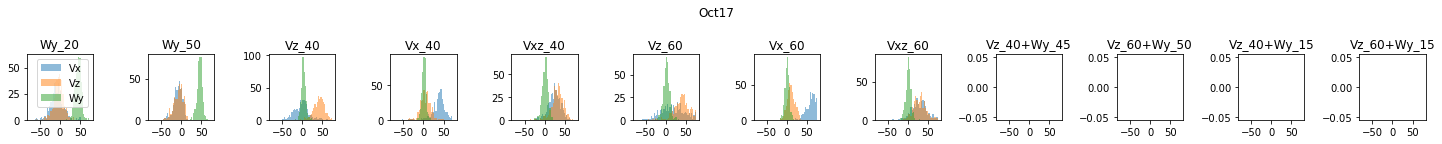

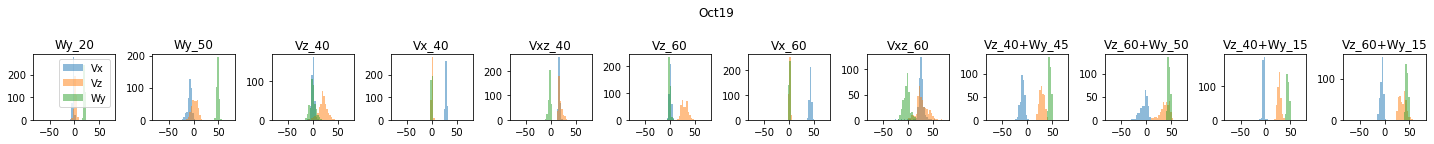

In [53]:
# confirm corrected estimates by site
rng = [-75,75]
bins = 50
for d,date in enumerate(dates):
    plt.figure(figsize=(20,2),facecolor='w')
    for s in range(len(speeds)):
        plt.subplot(1,len(speeds),s+1)
        ests = ests_3DOF_wholefield[d,s,:,:]
        plt.hist(ests[:,0],alpha=.5,range=rng,bins=bins,label=('Vx'))
        plt.hist(ests[:,1],alpha=.5,range=rng,bins=bins,label=('Vz'))
        plt.hist(ests[:,2],alpha=.5,range=rng,bins=bins,label=('Wy'));
        plt.title(speednames[s])
        if s==0:
            plt.legend()
    plt.suptitle(date)
    plt.tight_layout()

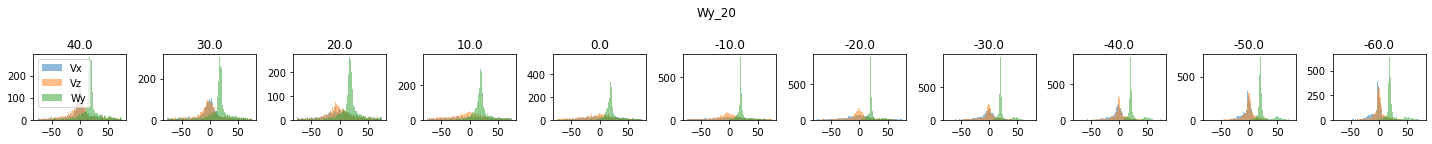

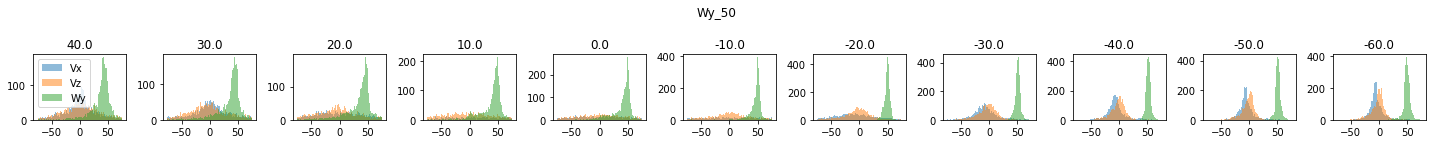

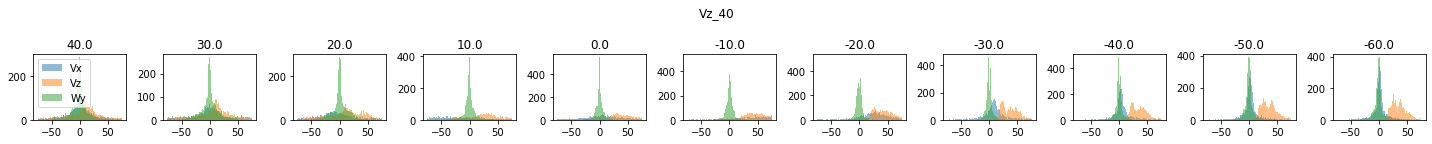

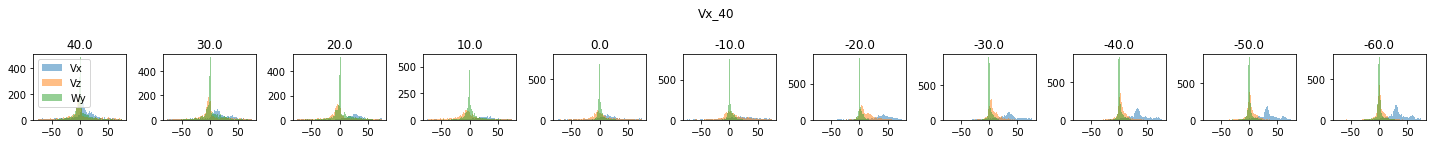

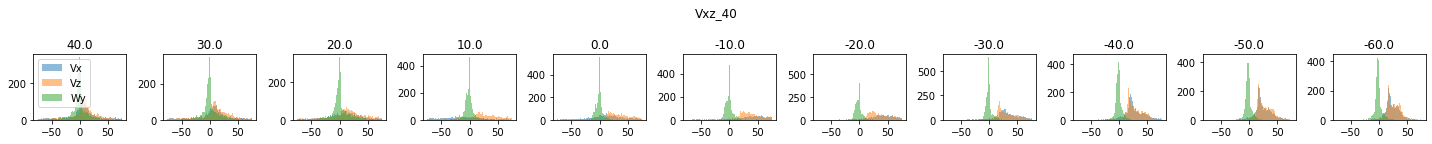

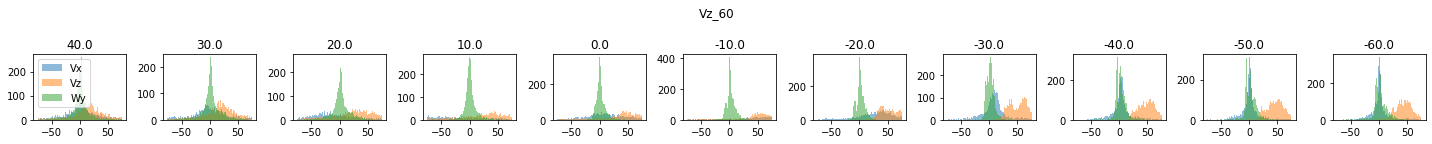

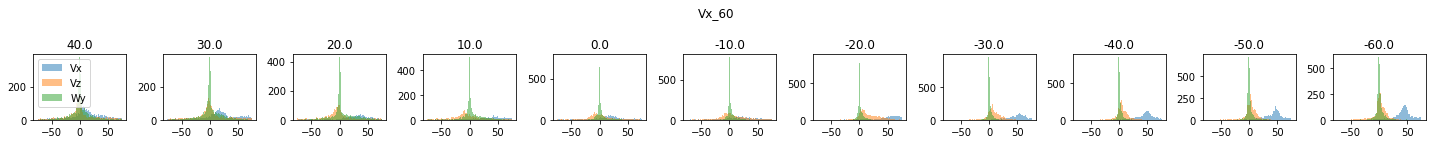

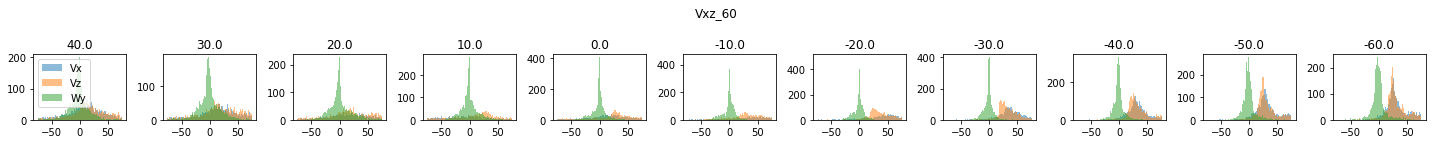

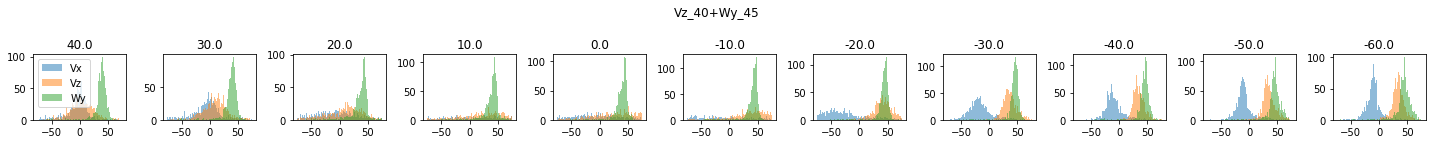

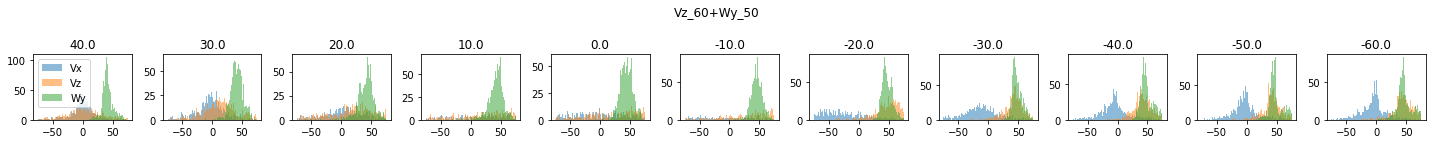

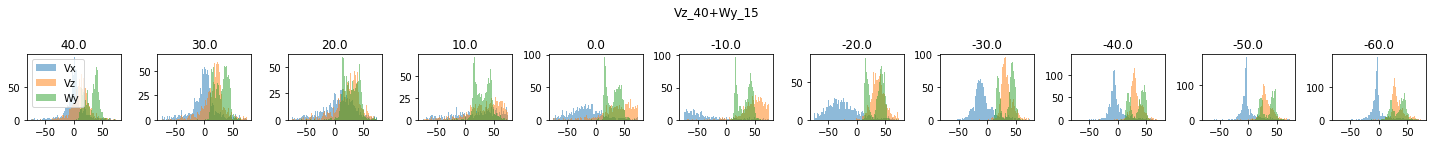

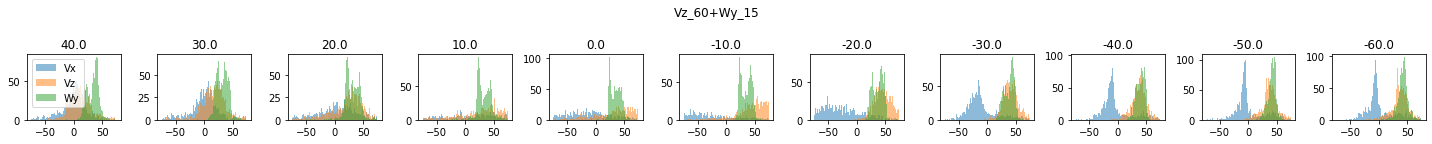

In [54]:
# show overall estimates by elevation
rng = [-75,75]
bins = 100
for s in range(len(speeds)):
    plt.figure(figsize=(20,2),facecolor='w')
    for e in range(len(elevs)):
        plt.subplot(1,len(elevs),e+1)
        ests = ests_3DOF[:,s,e,:,:]
        plt.hist(np.ndarray.flatten(ests[:,:,0]),alpha=.5,range=rng,bins=bins,label=('Vx'))
        plt.hist(np.ndarray.flatten(ests[:,:,1]),alpha=.5,range=rng,bins=bins,label=('Vz'))
        plt.hist(np.ndarray.flatten(ests[:,:,2]),alpha=.5,range=rng,bins=bins,label=('Wy'));
        plt.title(str(elevsdeg[e]))
        if e==0:
            plt.legend(loc='upper left')
    plt.suptitle(speednames[s])
    plt.tight_layout()

In [23]:
# calculate errors by elevation, speed

errs = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,4])
errs_loo = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,4])
errs_frombottom = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,4])
errs_fromtop = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,4])
errs_overall = np.nan*np.ones([len(dates),len(speeds),nframes,4])

def anglediff(a,b,deg=False):
    if deg:
        return np.arctan2(np.sin((a-b)*np.pi/180),np.cos((a-b)*np.pi/180))*180/np.pi
    else:
        return np.arctan2(np.sin(a-b),np.cos(a-b))

for s in range(len(speeds)):
    
    gt = speeds[s]
    print(gt)
    
    errs[:,s,:,:,:3] = np.abs(ests_3DOF[:,s,:,:,:] - gt)
    errs_loo[:,s,:,:,:3] = np.abs(ests_3DOF_leaveoneout[:,s,:,:,:] - gt)
    errs_frombottom[:,s,:,:,:3] = np.abs(ests_3DOF_frombottom[:,s,:,:,:]-gt)
    errs_fromtop[:,s,:,:,:3] = np.abs(ests_3DOF_fromtop[:,s,:,:,:]-gt)
    errs_overall[:,s,:,:3] = np.abs(ests_3DOF_wholefield[:,s,:,:] - gt)
    
    gtheading = np.arctan2(gt[1],gt[0])
    errs[:,s,:,:,-1] = np.abs(anglediff(gtheading,np.arctan2(ests_3DOF[:,s,:,:,1],ests_3DOF[:,s,:,:,0])))*180/pi
    errs_loo[:,s,:,:,-1] = np.abs(anglediff(gtheading,np.arctan2(ests_3DOF_leaveoneout[:,s,:,:,1],
                                                                 ests_3DOF_leaveoneout[:,s,:,:,0])))*180/pi
    errs_overall[:,s,:,-1] = np.abs(anglediff(gtheading,np.arctan2(ests_3DOF_wholefield[:,s,:,1],
                                                                   ests_3DOF_wholefield[:,s,:,0])))*180/pi
    errs_frombottom[:,s,:,:,-1] = np.abs(anglediff(gtheading,np.arctan2(ests_3DOF_frombottom[:,s,:,:,1],
                                                                 ests_3DOF_frombottom[:,s,:,:,0])))*180/pi
    errs_fromtop[:,s,:,:,-1] = np.abs(anglediff(gtheading,np.arctan2(ests_3DOF_fromtop[:,s,:,:,1],
                                                                 ests_3DOF_fromtop[:,s,:,:,0])))*180/pi
    
np.savez('./estimates/3DOFerrs',
 elevs=elevs,
 errs_singleelev=errs,
 errs_fromtbottom=errs_frombottom,
 errs_fromtop=errs_fromtop,
 errs_leaveoneout=errs_loo,
 errs_wholefield=errs_overall)

[ 0.  0. 20.]
[ 0.  0. 50.]
[ 0. 40.  0.]
[40.  0.  0.]
[28.28427125 28.28427125  0.        ]
[ 0. 60.  0.]
[60.  0.  0.]
[42.42640687 42.42640687  0.        ]
[ 0. 40. 45.]
[ 0. 60. 50.]
[ 0. 40. 15.]
[ 0. 60. 15.]


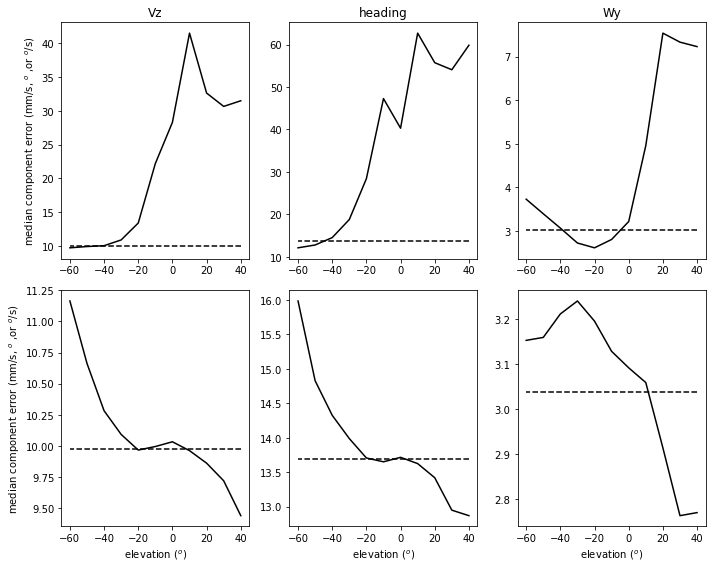

In [25]:
# for 3DOF estimation, by elevation, show {whole field, by elev, by elev leave one out} errors for {Vz, heading, rotation}

complabels = ['Vx','Vz','Wy','heading']
compcolors = ['k','k','k','k']
ylims = [[5,50],]


plt.figure(figsize=(10,8),facecolor='w')
j = 1
for comp in [1,3,2]:
    
    plt.subplot(2,3,j)
    plt.plot(elevsdeg,[np.nanmedian(errs[:,:,e,:,comp]) for e in range(len(elevs))],'-',c=compcolors[comp],label='single elevation included')
    plt.plot([elevsdeg[0],elevsdeg[-1]],[np.nanmedian(errs_overall[:,:,:,comp]),np.nanmedian(errs_overall[:,:,:,comp])],'--',color=compcolors[comp],label='full field')
    if j == 1:
        plt.ylabel(f'median component error (mm/s, $^o$ ,or $^o$/s)')
    plt.tight_layout()
    plt.title(complabels[comp])
    
    plt.subplot(2,3,3+j)
    plt.plot(elevsdeg,[np.nanmedian(errs_loo[:,:,e,:,comp]) for e in range(len(elevs))],'-',c=compcolors[comp],label='single elevation excluded')
    plt.plot([elevsdeg[0],elevsdeg[-1]],[np.nanmedian(errs_overall[:,:,:,comp]),np.nanmedian(errs_overall[:,:,:,comp])],'--',color=compcolors[comp],label='full field')
    if j == 1:
        plt.ylabel(f'median component error (mm/s, $^o$ ,or $^o$/s)')    
    plt.xlabel('elevation ($^o$)')
    
    j = j+1

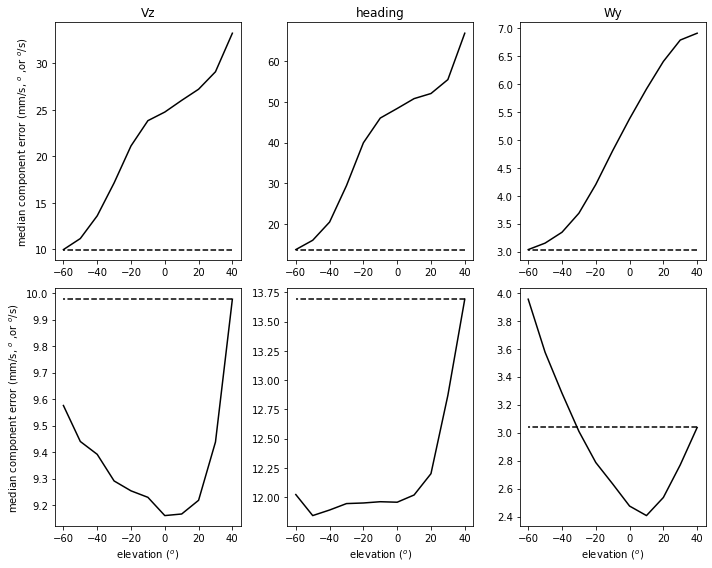

In [26]:
# for 3DOF estimation, by elevation, show {whole field, from top, from bottom} errors for {Vz, heading, rotation}

plt.figure(figsize=(10,8),facecolor='w')
j = 1
for comp in [1,3,2]:
    
    plt.subplot(2,3,j)
    plt.plot(elevsdeg,[np.nanmedian(errs_fromtop[:,:,e,:,comp]) for e in range(len(elevs))],'-',c=compcolors[comp],label='single elevation included')
    plt.plot([elevsdeg[0],elevsdeg[-1]],[np.nanmedian(errs_overall[:,:,:,comp]),np.nanmedian(errs_overall[:,:,:,comp])],'--',color=compcolors[comp],label='full field')
    if j == 1:
        plt.ylabel(f'median component error (mm/s, $^o$ ,or $^o$/s)')
    plt.tight_layout()
    plt.title(complabels[comp])
    
    plt.subplot(2,3,3+j)
    plt.plot(elevsdeg,[np.nanmedian(errs_frombottom[:,:,e,:,comp]) for e in range(len(elevs))],'-',c=compcolors[comp],label='single elevation excluded')
    plt.plot([elevsdeg[0],elevsdeg[-1]],[np.nanmedian(errs_overall[:,:,:,comp]),np.nanmedian(errs_overall[:,:,:,comp])],'--',color=compcolors[comp],label='full field')
    if j == 1:
        plt.ylabel(f'median component error (mm/s, $^o$ ,or $^o$/s)')    
    plt.xlabel('elevation ($^o$)')
    
    j = j+1

In [ ]:
# Comparison to Simulation

In [ ]:
# simulated estimates to make sure geometry isn't the issue
# use same p0s and matchsts for real sparsity and real point distribution
# only remaining unmatched factor is higher order noise stats

simests_3DOF = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,3])
simests_3DOF_leaveoneout = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,3])
simests_3DOF_frombottom = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,3])
simests_3DOF_fromtop = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,3])
simests_3DOF_wholefield = np.nan*np.ones([len(dates),len(speeds),nframes,3])

recalculate = False

In [22]:
# make noisy by model
from scipy import stats

# defauly 0 sparsity, real locations and matchsts determines sparsity now
def gengaussnoise(sample,params,sparsity=0,delvalue=np.nan):
    out = np.copy(sample)
    _,h = np.shape(sample)
    # add generalized Gaussian noise
    sig = params[0]
    beta = params[1]
    noise = sig*stats.gennorm.rvs(beta,size=2*h)
    noise = np.reshape(noise,[2,h])
    out = out+(noise*np.pi/180) # noise model based on deg/sec
    # sparsify
    delete = np.random.rand(h)>(1-sparsity)
    out[np.stack([delete,delete],axis=0)] = delvalue
    return out

# Lukas-Kanade noise models -- see NaturalFlowModel code and methods for details
LK = {
    'name': 'LK',
    'params': np.array([[0.945543  , 0.41324449],
       [0.75939695, 0.40043585],
       [0.84083792, 0.41700667],
       [0.71956128, 0.43254874],
       [0.76700457, 0.46822423],
       [0.97988532, 0.51886733],
       [1.18255235, 0.55071252],
       [1.35039504, 0.56855028],
       [1.69578376, 0.59252586],
       [2.18604247, 0.6292485 ],
       [2.36382315, 0.62748426]]),
    'sparsities': [.6134260585, .6251135201, .6372243813, .6701022704, .6488167314, .5720433627,
                   .4841859276, .3977214154, .3323757415, .30228063,   .2793106975]}

In [27]:
if recalculate:

    def getflowinds(flow,inds):
        xflow = np.nan*np.ones(len(inds)*2*patchsz)
        yflow = np.nan*np.ones(len(inds)*2*patchsz)
        for i,ind in enumerate(inds):
            xflow[i*patchsz:(i+1)*patchsz] = sflow[0,ind*patchsz:(ind+1)*patchsz]
            xflow[(i+len(inds))*patchsz:(i+len(inds)+1)*patchsz] = sflow[0,(ind+len(elevs))*patchsz:(ind+len(elevs)+1)*patchsz]
            yflow[i*patchsz:(i+1)*patchsz] = sflow[1,ind*patchsz:(ind+1)*patchsz]
            yflow[(i+len(inds))*patchsz:(i+len(inds)+1)*patchsz] = sflow[1,(ind+len(elevs))*patchsz:(ind+len(elevs)+1)*patchsz]
        return xflow, yflow


    for d in range(3,len(dates)):
        print(dates[d])

        for s in range(len(speeds)):
            print('\t'+speednames[s])

            data = np.load(f'{srcdir}{speednames[s]}/{speednames[s]}_{dates[d]}.npz')
            p0s = (data['p0s']-center)/pixperdeg*pi/180
            p1s = (data['p1s']-center)/pixperdeg*pi/180
            matchsts = np.repeat(data['matchsts'],2,axis=-1)
            p0s[matchsts!=1] = np.nan
            p1s[matchsts!=1] = np.nan

            for f in range(nframes):
                if np.all(np.isnan(p0s[:,:,f,:])):
                    continue

                gtspeed = speeds[s]
                sflowclean = np.array(getflow_multimodal(np.ndarray.flatten(p0s[:,:,f,xinds]),
                                                             np.ndarray.flatten(p0s[:,:,f,yinds]),
                                                             thetas=np.repeat([-pi/2,pi/2],len(elevs)),
                                                             alphas=np.tile(elevs,2),
                                                             Vx=gtspeed[0],Vz=gtspeed[1],Wy=gtspeed[2]))

                sflow = np.copy(sflowclean)
                for i in range(len(elevs)):
                    sflow[:,i*patchsz:(i+1)*patchsz] = gengaussnoise(sflow[:,i*patchsz:(i+1)*patchsz],
                                                                    params=LK['params'][i],sparsity=0)
                    i2 = i + len(elevs) # get other camera
                    sflow[:,i2*patchsz:(i2+1)*patchsz] = gengaussnoise(sflow[:,i2*patchsz:(i2+1)*patchsz],
                                                                       params=LK['params'][i],sparsity=0)



                simests_3DOF_wholefield[d,s,f] = getvel_multimodal(np.ndarray.flatten(p0s[:,:,f,xinds]),
                                                         np.ndarray.flatten(p0s[:,:,f,yinds]),
                                                         [np.ndarray.flatten(sflow[0]),np.ndarray.flatten(sflow[1])],
                                                         thetas=np.repeat([-pi/2,pi/2],len(elevs)),
                                                         alphas=np.tile(elevs,2),
                                                         DOFs=3)

                for e in range(len(elevs)):

                    inds = [e]
                    p0s_temp = p0s[:,inds,:,:]
                    xflow,yflow = getflowinds(sflow,inds)
                    simests_3DOF[d,s,e,f] = getvel_multimodal(np.ndarray.flatten(p0s[:,e,f,xinds]),
                                                           np.ndarray.flatten(p0s[:,e,f,xinds]),
                                                           [xflow,yflow],
                                                           thetas=[-pi/2,pi/2],
                                                           alphas=[elevs[e],elevs[e]],
                                                           DOFs=3)

                    inds = [ind for ind in range(len(elevs)) if ind !=e]
                    p0s_temp = p0s[:,inds,:,:]
                    xflow,yflow = getflowinds(sflow,inds)
                    simests_3DOF_leaveoneout[d,s,e,f] = getvel_multimodal(np.ndarray.flatten(p0s_temp[:,:,f,xinds]),
                                                         np.ndarray.flatten(p0s_temp[:,:,f,yinds]),
                                                         [xflow,yflow],
                                                         thetas=np.repeat([-pi/2,pi/2],len(elevs)-1),
                                                         alphas=np.tile(elevs[inds],2),
                                                         DOFs=3)

                    inds = [ind for ind in range(len(elevs)) if ind >= e] # >= because elevs go max to min
                    p0s_temp = p0s[:,inds,:,:]
                    xflow,yflow = getflowinds(sflow,inds)
                    simests_3DOF_frombottom[d,s,e,f] = getvel_multimodal(np.ndarray.flatten(p0s_temp[:,:,f,xinds]),
                                                         np.ndarray.flatten(p0s_temp[:,:,f,yinds]),
                                                         [xflow,yflow],
                                                         thetas=np.repeat([-pi/2,pi/2],len(inds)),
                                                         alphas=np.tile(elevs[inds],2),
                                                         DOFs=3)

                    inds = [ind for ind in range(len(elevs)) if ind <= e]
                    p0s_temp = p0s[:,inds,:,:]
                    xflow,yflow = getflowinds(sflow,inds)
                    simests_3DOF_fromtop[d,s,e,f] = getvel_multimodal(np.ndarray.flatten(p0s_temp[:,:,f,xinds]),
                                                         np.ndarray.flatten(p0s_temp[:,:,f,yinds]),
                                                         [xflow,yflow],
                                                         thetas=np.repeat([-pi/2,pi/2],len(inds)),
                                                         alphas=np.tile(elevs[inds],2),
                                                         DOFs=3)


                np.savez('./estimates/simests',
                              simests_3DOF=simests_3DOF,
                              simests_3DOF_frombottom=simests_3DOF_frombottom,
                              simests_3DOF_fromtop=simests_3DOF_fromtop,
                              simests_3DOF_wholefield=simests_3DOF_wholefield,
                              simests_3DOF_leaveoneout=simests_3DOF_leaveoneout)
    
else:
    ests = np.load('./estimates_orig/sests.npz')
    simests_3DOF = ests['sests_3DOF']
    simests_3DOF_frombottom = ests['sests_3DOF_fromtop']
    simests_3DOF_fromtop = ests['sests_3DOF_frombottom']
    simests_3DOF_wholefield = ests['sests_3DOF_wholefield']
    simests_3DOF_leaveoneout = ests['sests_3DOF_leaveoneout']

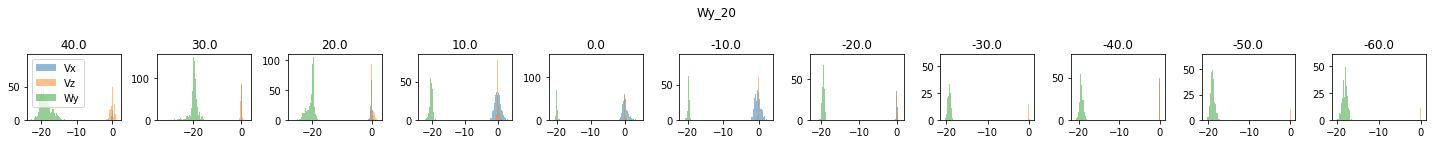

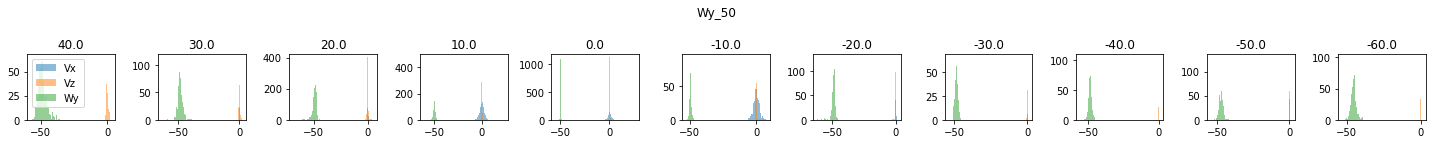

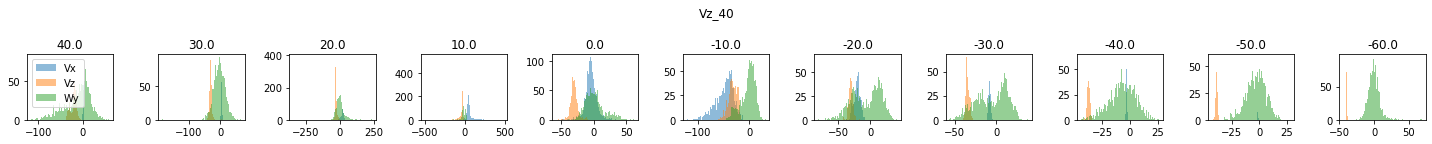

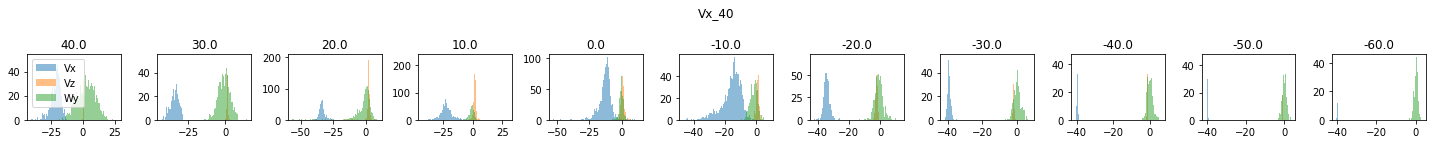

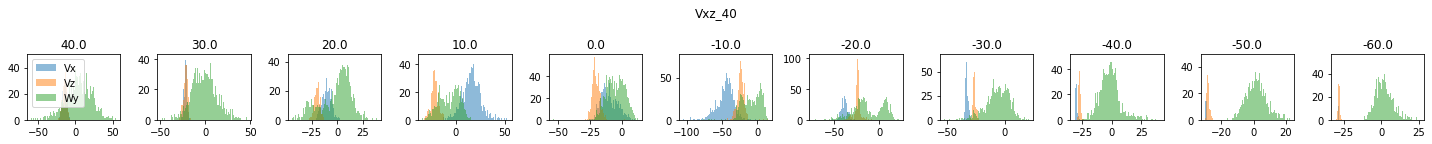

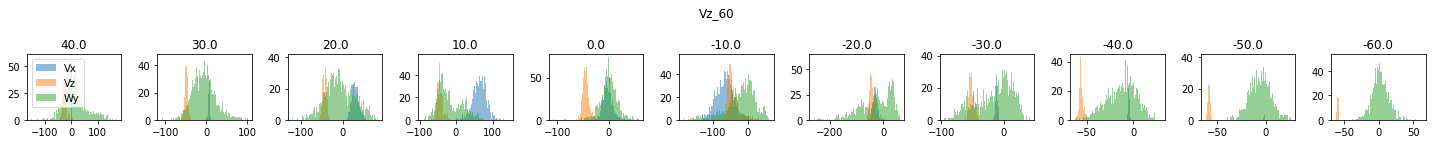

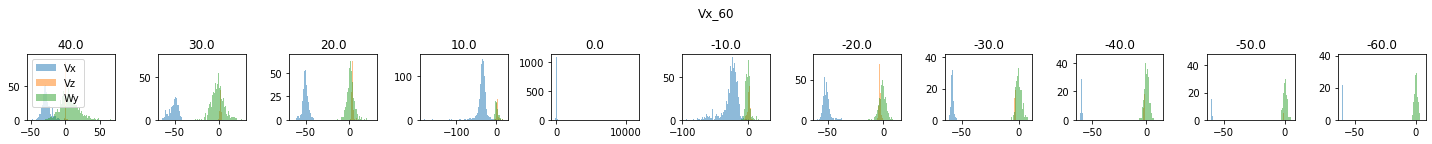

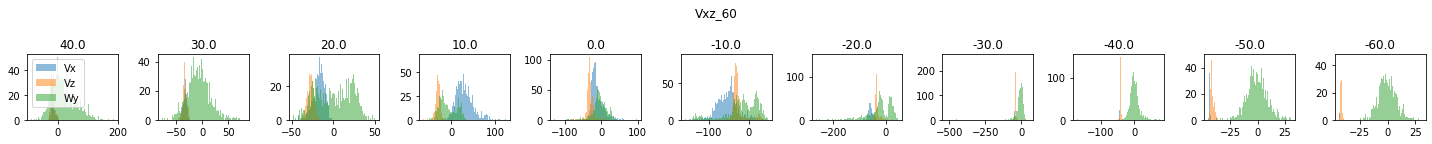

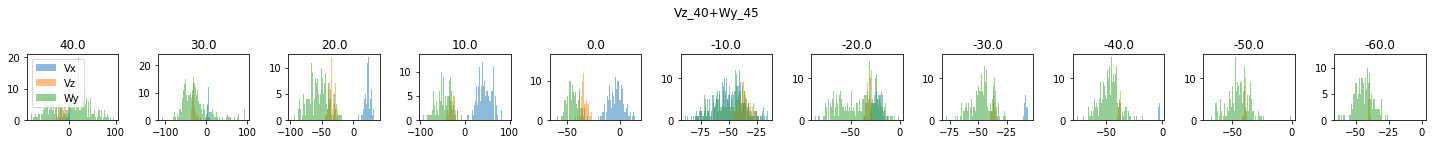

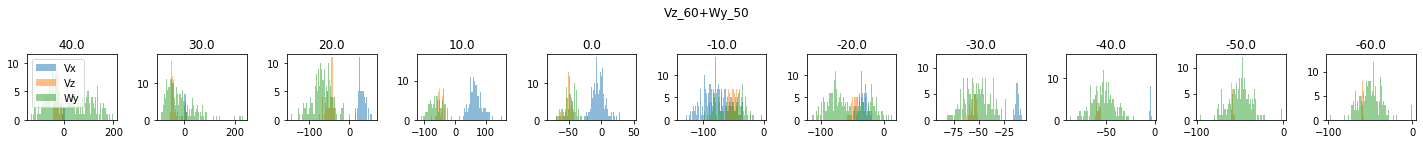

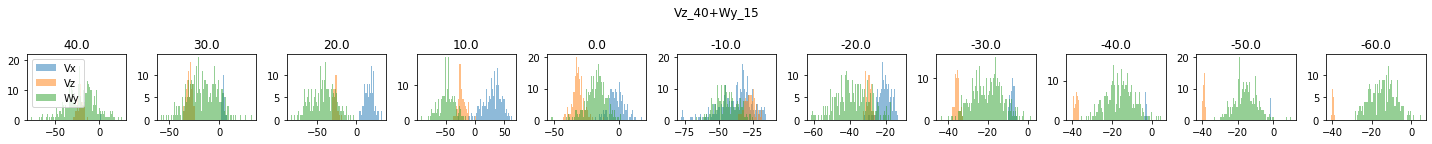

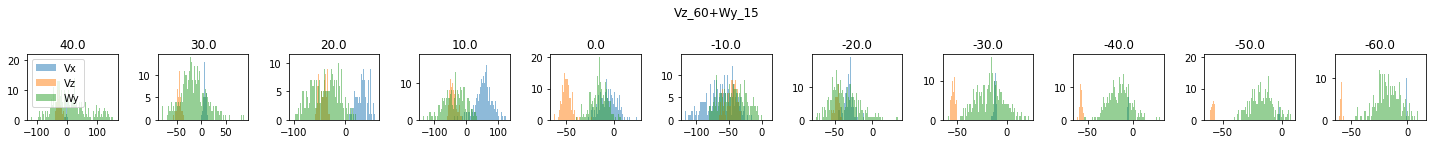

In [15]:
# show overall estimates by elevation
bins = 100
for s in range(len(speeds)):
    plt.figure(figsize=(20,2),facecolor='w')
    for e in range(len(elevs)):
        plt.subplot(1,len(elevs),e+1)
        ests = simests_3DOF[:,s,e,:,:]
        plt.hist(np.ndarray.flatten(ests[:,:,0]),alpha=.5,bins=bins,label=('Vx'))
        plt.hist(np.ndarray.flatten(ests[:,:,1]),alpha=.5,bins=bins,label=('Vz'))
        plt.hist(np.ndarray.flatten(ests[:,:,2]),alpha=.5,bins=bins,label=('Wy'));
        plt.title(str(elevsdeg[e]))
        if e==0:
            plt.legend(loc='upper left')
    plt.suptitle(speednames[s])
    plt.tight_layout()

In [34]:
# calculate errors by elevation, speed

simerrs = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,4])
simerrs_loo = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,4])
simerrs_frombottom = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,4])
simerrs_fromtop = np.nan*np.ones([len(dates),len(speeds),len(elevs),nframes,4])
simerrs_overall = np.nan*np.ones([len(dates),len(speeds),nframes,4])
    
for s in range(len(speeds)):
    
    gt = speeds[s]
    print(gt)
    print([np.nanmedian(simests_3DOF[:,s,:,:,i]) for i in range(3)])
    
    simerrs[:,s,:,:,:3] = np.abs(simests_3DOF[:,s,:,:,:] - gt)
    simerrs_loo[:,s,:,:,:3] = np.abs(simests_3DOF_leaveoneout[:,s,:,:,:] - gt)
    simerrs_frombottom[:,s,:,:,:3] = np.abs(simests_3DOF_frombottom[:,s,:,:,:]-gt)
    simerrs_fromtop[:,s,:,:,:3] = np.abs(simests_3DOF_fromtop[:,s,:,:,:]-gt)
    simerrs_overall[:,s,:,:3] = np.abs(simests_3DOF_wholefield[:,s,:,:] - gt)
    
    gtheading = np.arctan2(gt[1],gt[0])
    simerrs[:,s,:,:,-1] = np.abs(anglediff(gtheading,np.arctan2(simests_3DOF[:,s,:,:,1],simests_3DOF[:,s,:,:,0])))*180/pi
    simerrs_loo[:,s,:,:,-1] = np.abs(anglediff(gtheading,np.arctan2(simests_3DOF_leaveoneout[:,s,:,:,1],
                                                                 simests_3DOF_leaveoneout[:,s,:,:,0])))*180/pi
    simerrs_overall[:,s,:,-1] = np.abs(anglediff(gtheading,np.arctan2(simests_3DOF_wholefield[:,s,:,1],
                                                                   simests_3DOF_wholefield[:,s,:,0])))*180/pi
    simerrs_frombottom[:,s,:,:,-1] = np.abs(anglediff(gtheading,np.arctan2(simests_3DOF_frombottom[:,s,:,:,1],
                                                                 simests_3DOF_frombottom[:,s,:,:,0])))*180/pi
    simerrs_fromtop[:,s,:,:,-1] = np.abs(anglediff(gtheading,np.arctan2(simests_3DOF_fromtop[:,s,:,:,1],
                                                                 simests_3DOF_fromtop[:,s,:,:,0])))*180/pi
    

[ 0.  0. 20.]
[0.00425951479113843, 0.016811695880563388, 19.513728131323017]
[ 0.  0. 50.]
[-0.000577030933498882, 0.009121001802452719, 48.72683644859986]
[ 0. 40.  0.]
[1.167026273918494, 33.689337227748695, 0.946678289385068]
[40.  0.  0.]
[34.541806689055406, 0.37298773301747834, 0.08363900108697352]
[28.28427125 28.28427125  0.        ]
[28.61073370173805, 23.737091919852503, -0.31081944637791087]
[ 0. 60.  0.]
[1.6819713749314105, 49.69738018888109, -0.89465593994455]
[60.  0.  0.]
[51.57638510557151, 0.5948715576855127, -0.08585814726227228]
[42.42640687 42.42640687  0.        ]
[42.80570368052675, 35.69787059302923, -1.3185034214524778]
[ 0. 40. 45.]
[1.3303224786208814, 33.82618520950812, 47.114383440638214]
[ 0. 60. 50.]
[1.9223655148932732, 50.534453717032434, 55.65570104181175]
[ 0. 40. 15.]
[1.2638314598517004, 33.38408374952319, 16.48698727163398]
[ 0. 60. 15.]
[1.9271262723833567, 49.54453246695339, 19.852313904088813]


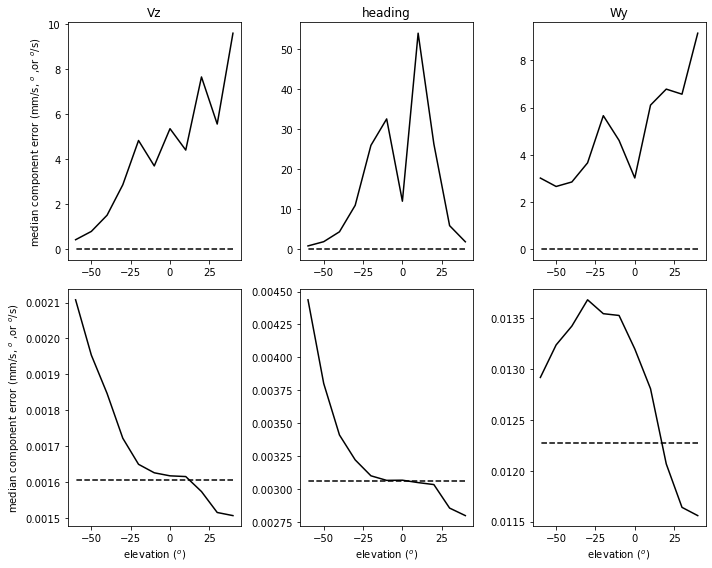

In [36]:
# for simualted 3DOF estimation, by elevation, show {whole field, by elev, by elev leave one out} errors for {Vz, heading, rotation}

complabels = ['Vx','Vz','Wy','heading']
compcolors = ['k','k','k','k']
ylims = [[5,50],]


plt.figure(figsize=(10,8),facecolor='w')
j = 1
for comp in [1,3,2]:
    
    plt.subplot(2,3,j)
    plt.plot(elevsdeg,[np.nanmedian(simerrs[:,:,e,:,comp]) for e in range(len(elevs))],'-',c=compcolors[comp],label='single elevation included')
    plt.plot([elevsdeg[0],elevsdeg[-1]],[np.nanmedian(simerrs_overall[:,:,:,comp]),np.nanmedian(simerrs_overall[:,:,:,comp])],'--',color=compcolors[comp],label='full field')
    if j == 1:
        plt.ylabel(f'median component error (mm/s, $^o$ ,or $^o$/s)')
    plt.tight_layout()
    plt.title(complabels[comp])
    
    plt.subplot(2,3,3+j)
    plt.plot(elevsdeg,[np.nanmedian(simerrs_loo[:,:,e,:,comp]) for e in range(len(elevs))],'-',c=compcolors[comp],label='single elevation excluded')
    plt.plot([elevsdeg[0],elevsdeg[-1]],[np.nanmedian(simerrs_overall[:,:,:,comp]),np.nanmedian(simerrs_overall[:,:,:,comp])],'--',color=compcolors[comp],label='full field')
    if j == 1:
        plt.ylabel(f'median component error (mm/s, $^o$ ,or $^o$/s)')    
    plt.xlabel('elevation ($^o$)')
    
    j = j+1

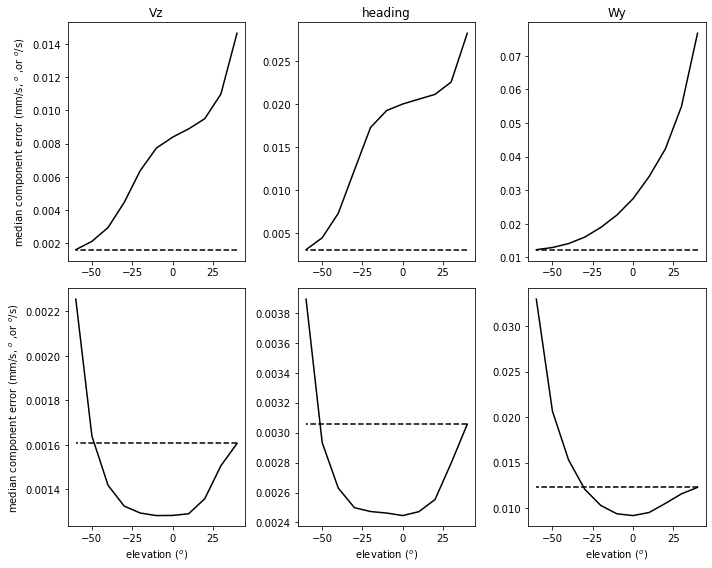

In [37]:
# for simualted 3DOF estimation, by elevation, show {whole field, by elev, by elev leave one out} errors for {Vz, heading, rotation}

complabels = ['Vx','Vz','Wy','heading']
compcolors = ['k','k','k','k']
ylims = [[5,50],]


plt.figure(figsize=(10,8),facecolor='w')
j = 1
for comp in [1,3,2]:
    
    plt.subplot(2,3,j)
    plt.plot(elevsdeg,[np.nanmedian(simerrs_fromtop[:,:,e,:,comp]) for e in range(len(elevs))],'-',c=compcolors[comp],label='single elevation included')
    plt.plot([elevsdeg[0],elevsdeg[-1]],[np.nanmedian(simerrs_overall[:,:,:,comp]),np.nanmedian(simerrs_overall[:,:,:,comp])],'--',color=compcolors[comp],label='full field')
    if j == 1:
        plt.ylabel(f'median component error (mm/s, $^o$ ,or $^o$/s)')
    plt.tight_layout()
    plt.title(complabels[comp])
    
    plt.subplot(2,3,3+j)
    plt.plot(elevsdeg,[np.nanmedian(simerrs_frombottom[:,:,e,:,comp]) for e in range(len(elevs))],'-',c=compcolors[comp],label='single elevation excluded')
    plt.plot([elevsdeg[0],elevsdeg[-1]],[np.nanmedian(simerrs_overall[:,:,:,comp]),np.nanmedian(simerrs_overall[:,:,:,comp])],'--',color=compcolors[comp],label='full field')
    if j == 1:
        plt.ylabel(f'median component error (mm/s, $^o$ ,or $^o$/s)')    
    plt.xlabel('elevation ($^o$)')
    
    j = j+1